# はじめに

[横向きスタイル](https://github.com/jupyter/notebook/issues/2897)を適用してみた。悪くない感じ。
notebookの幅も9割と十分な幅を持っている。

In [2]:
%%html
<style>
#notebook-container {
    width: 90%;
    background-color: #EEE
}

.code_cell {
   flex-direction: row !important;
}

.code_cell .output_wrapper {
    width: 50%;
    background-color: #FFF
}

.code_cell .input {
    width: 50%;
    background-color: #FFF
}
</style>

系はサンプリング時間で離散化されているとする。
状態方程式は，

観測として位置センサ，速度センサ，加速度センサの3つを考える。
したがって観測行列としてはそれぞれ次のようになる。


In [3]:
% sampling
ST = 0.001;

% Simulation Length
len = 1000
time = 0:ST:ST*(len-1);


len =

        1000




In [4]:
% A matrix
A = [1 ST 0;
    0 1 ST;
    0 0 1];

% C matrix
c1 = [1 0 0]; % position sensor
c2 = [0 1 0]; % vel
c3 = [0 0 1]; % acc

## 一般可観測性指数とその逆行列
一般可観測性指数を仮に$C=[c_1^\top, c_1^\top A, c_2^\top ]^\top$とする。
その時の観測を$Y=[y_1[2i], y_1[2i+1], y_2[2i]]^\top$とする。

$$
Y = C x[2i]
$$

この時，$\hat{x}[2i]=C^{-1}Y$である。

$$
V(Y) = diag(\sigma_1^2,\sigma_1^2,\sigma_2^2)
$$

より

$$
V(\hat{x}[2i]) = V(C^{-1}Y)= C^{-1}V(Y)(C^{-1})^\top
$$

In [14]:
%% Pattern 1: Obserbility Matrix for Each sensor
Mo1_1 = [c1;c1*A;c1*A^2]
Mo1_2 = [c2;c2*A;c2*A^2]
Mo1_3 = [c3;c3*A;c3*A^2]
Mo2_4 = [c1;c1*A;c2;c2*A]
iMo2_1 = inv(Mo2_1)
iMo2_2 = inv(Mo2_2)
iMo2_3 = inv(Mo2_3)
iMo2_4 = pinv(Mo2_4)


Mo1_1 =

    1.0000         0         0
    1.0000    0.0010         0
    1.0000    0.0020    0.0000


Mo1_2 =

         0    1.0000         0
         0    1.0000    0.0010
         0    1.0000    0.0020


Mo1_3 =

     0     0     1
     0     0     1
     0     0     1


Mo2_4 =

    1.0000         0         0
    1.0000    0.0010         0
         0    1.0000         0
         0    1.0000    0.0010


iMo2_1 =

   1.0e+06 *

    0.0000         0         0
   -0.0010    0.0010   -0.0000
    1.0000   -1.0000    0.0010


iMo2_2 =

           1           0           0
           0           1           0
           0       -1000        1000


iMo2_3 =

   1.0e+03 *

    0.0010   -0.0000         0
         0    0.0010         0
         0   -1.0000    1.0000


iMo2_4 =

   1.0e+03 *

    0.0005    0.0005   -0.0000   -0.0000
   -0.0000    0.0000    0.0010    0.0000
    0.0005   -0.0005   -1.0000    1.0000




# データ作成


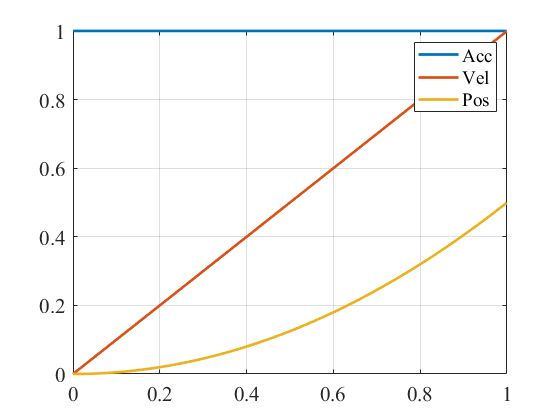

In [7]:
%% make input
Acc0 = 1;
acc = Acc0 * ones(1,len);
vel = Acc0*time;
pos = Acc0/2*time.*time;
figure
plot(time,acc,time,vel,time,pos)
legend('Acc','Vel','Pos')
grid on

## ノイズありの観測

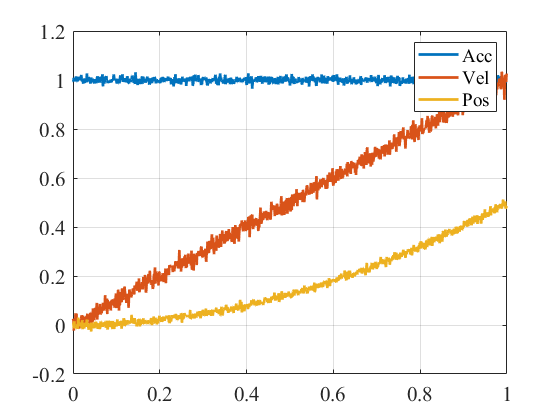

In [12]:
% Measurement with noise
sigma1 = 0.01;
sigma2 = 0.02;
sigma3 = 0.01;

pos_ = pos + sigma1*randn(1,len);
vel_ = vel + sigma2*randn(1,len);
acc_ = acc + sigma3*randn(1,len);
figure
plot(time,acc_,time,vel_,time,pos_)
legend('Acc','Vel','Pos')
grid on

## 一般可観測性指数によるノイズ推定

In [15]:
Mo2_1 = [c1;c1*A;c2*A];
Mo2_2 = [c1;c2;c2*A];
Mo2_3 = [c1*A;c2;c2*A];


Go2_1 = iMo2_1*diag([sigma1;sigma1;sigma2].^2)*iMo2_1'
Go2_2 = iMo2_2*diag([sigma1;sigma2;sigma2].^2)*iMo2_2'
Go2_3 = iMo2_3*diag([sigma1;sigma2;sigma2].^2)*iMo2_3'
Go2_4 = iMo2_4*diag([sigma1;sigma1;sigma2;sigma2].^2)*iMo2_4'


Go2_1 =

   1.0e+08 *

    0.0000   -0.0000    0.0000
   -0.0000    0.0000   -0.0020
    0.0000   -0.0020    2.0000


Go2_2 =

    0.0001         0         0
         0    0.0004   -0.4000
         0   -0.4000  800.0000


Go2_3 =

    0.0001   -0.0000    0.0004
   -0.0000    0.0004   -0.4000
    0.0004   -0.4000  800.0000


Go2_4 =

    0.0001   -0.0000    0.0002
   -0.0000    0.0004   -0.4000
    0.0002   -0.4000  799.9997




- 実際の分散は共分散行列の逆行列の対角成分の逆数になるはず

In [18]:
1./diag(inv(Go2_1) )
1./diag(inv(Go2_2) )
1./diag(inv(Go2_3) )
1./diag(inv(Go2_4) )


ans =

    0.0001
    0.0004
  400.0000


ans =

    0.0001
    0.0002
  400.0000


ans =

    0.0001
    0.0002
  400.0000


ans =

    0.0000
    0.0002
  400.0000




In [21]:
multirate_estimation_LS(len,time,pos,vel,acc,pos_,vel_,acc_,Mo2_1,Mo2_2,Mo2_3,Mo2_4);

関数としてスクリプト multirate_estimation_LS を実行しようとしています:
C:\Users\hkedw\Documents\GitHub\Lin_Algebra_memo\src\MultirateOBS\multirate_estimation_LS.m

